In [2]:
from functools import cache
from itertools import chain, repeat

import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
results = joblib.load('../../../5_evaluation/large/results.sav')['real']

No-Effect vs. Effect
No-Effect vs. Cyto
Cyto vs. Effect


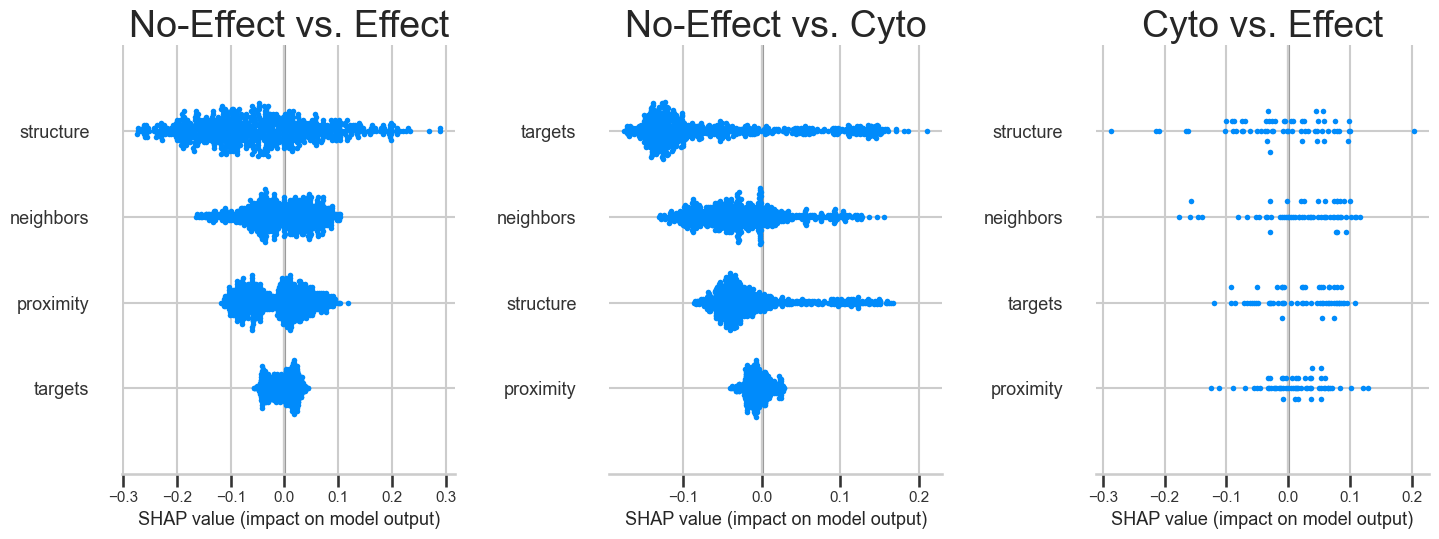

In [8]:
sns.set("talk", font_scale=1.5)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=100, sharex='col')
i = 0
for key in results.keys():
    print(key)
    labels = key.split(' vs. ')
    model = results[key]['model']
    X = results[key]['X_test']
    rf = model['clf']
    var_thresh: VarianceThreshold = model['var_thresh']
    scaler = model['scaler']
    imputer = model['imputer']
    X_var = var_thresh.transform(X)
    X_scale = scaler.transform(X_var)
    X_impute = imputer.transform(X_scale)
    X = pd.DataFrame(data=X_impute, index=X.index, columns=var_thresh.get_feature_names_out(input_features=X.columns))
    explainer = shap.TreeExplainer(rf)
    groups = {
        'structure': [f for f in X if 'target' not in f and 'neighbor' not in f and 'cov' not in f],
        'targets': [f for f in X if 'target' in f and 'cov' not in f],
        'neighbors': [f for f in X if 'neighbor' in f and 'cov' not in f],
        'proximity': [f for f in X if 'cov' in f]
    }
    shap_values = explainer.shap_values(X)
    shap_group = grouped_shap(shap_values[1], X.columns.tolist(), groups)

    plt.sca(axes[i])
    axes[i].set(title=f'{labels[0]} vs. {labels[1]}')
    shap.summary_plot(shap_group.values, features=shap_group.columns, show=False, max_display=15, plot_size=None)
    plt.tight_layout()

    i += 1

fig.savefig('shap_features.png', format="png", dpi=300)
fig.savefig('shap_features.pdf', format="pdf", dpi=300)